In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from jupyterthemes import jtplot
jtplot.style(theme="grade3")

In [2]:
def cap(x,quantile=[0.01,0.99]):
    """
    CAP Algorithm to delete the outliers
    
    Args：
        x：pd.Series
        quantile：upper/lower boundary in precentage
    """

    Q01,Q99=x.quantile(quantile).values.tolist()

    if Q01 > x.min():
        x = x.copy()
        x.loc[x<Q01] = Q01

    if Q99 < x.max():
        x = x.copy()
        x.loc[x>Q99] = Q99

    return(x)

# Load Data

In [3]:
datasize = ["256", "512", "128K", "256K"]
datatype = ["Real-Time_Unloaded_FreqDisable", "Real-Time_Loaded_FreqDisable", "NonReal-Time_Unloaded_FreqDisable", "NonReal-Time_Loaded_FreqDisable",
            "Real-Time_Unloaded_FreqEnable", "Real-Time_Loaded_FreqEnable", "NonReal-Time_Unloaded_FreqEnable", "NonReal-Time_Loaded_FreqEnable"]

data = np.zeros([len(datatype), 600, len(datasize)])

for i in range(len(datatype)):
    path = "./q5/" + datatype[i] + "/"
    for j in range(len(datasize)):
        data[i, :, j] = np.loadtxt(path+"transport_time_"+datasize[j]+"byte.txt", dtype=np.float64) * 1000 # convert "s" to "ms"

data = data[:, 30:, :] # drop the first 30 outliers

In [4]:
realTimeSmall = np.hstack((data[0, :, :2], data[1, :, :2], data[4, :, :2], data[5, :, :2]))
realTimeLarge = np.hstack((data[0, :, 2:], data[1, :, 2:], data[4, :, 2:], data[5, :, 2:]))
nonRealTimeSmall = np.hstack((data[2, :, :2], data[3, :, :2], data[6, :, :2], data[7, :, :2]))
nonRealTimeLarge = np.hstack((data[2, :, 2:], data[3, :, 2:], data[6, :, 2:], data[7, :, 2:]))

# Make pd.Dataframe

In [5]:
colums_small = ["256-FreqScaleDisable", "512-FreqScaleDisable", "256-Loaded-FreqScaleDisable", "512-Loaded-FreqScaleDisable",
               "256-FreqScaleEnable", "512-FreqScaleEnable", "256-Loaded-FreqScaleEnable", "512-Loaded-FreqScaleEnable"]
colums_large = ["128K-FreqScaleDisable", "256K-FreqScaleDisable", "128K-Loaded-FreqScaleDisable", "256K-Loaded-FreqScaleDisable",
               "128K-FreqScaleEnable", "256K-FreqScaleEnable", "128K-Loaded-FreqScaleEnable", "256K-Loaded-FreqScaleEnable"]

pd_rts = pd.DataFrame(data=realTimeSmall, columns=colums_small)
pd_rtl = pd.DataFrame(data=realTimeLarge, columns=colums_large)
pd_nrts = pd.DataFrame(data=nonRealTimeSmall, columns=colums_small)
pd_nrtl = pd.DataFrame(data=nonRealTimeLarge, columns=colums_large)

# Box-Plot

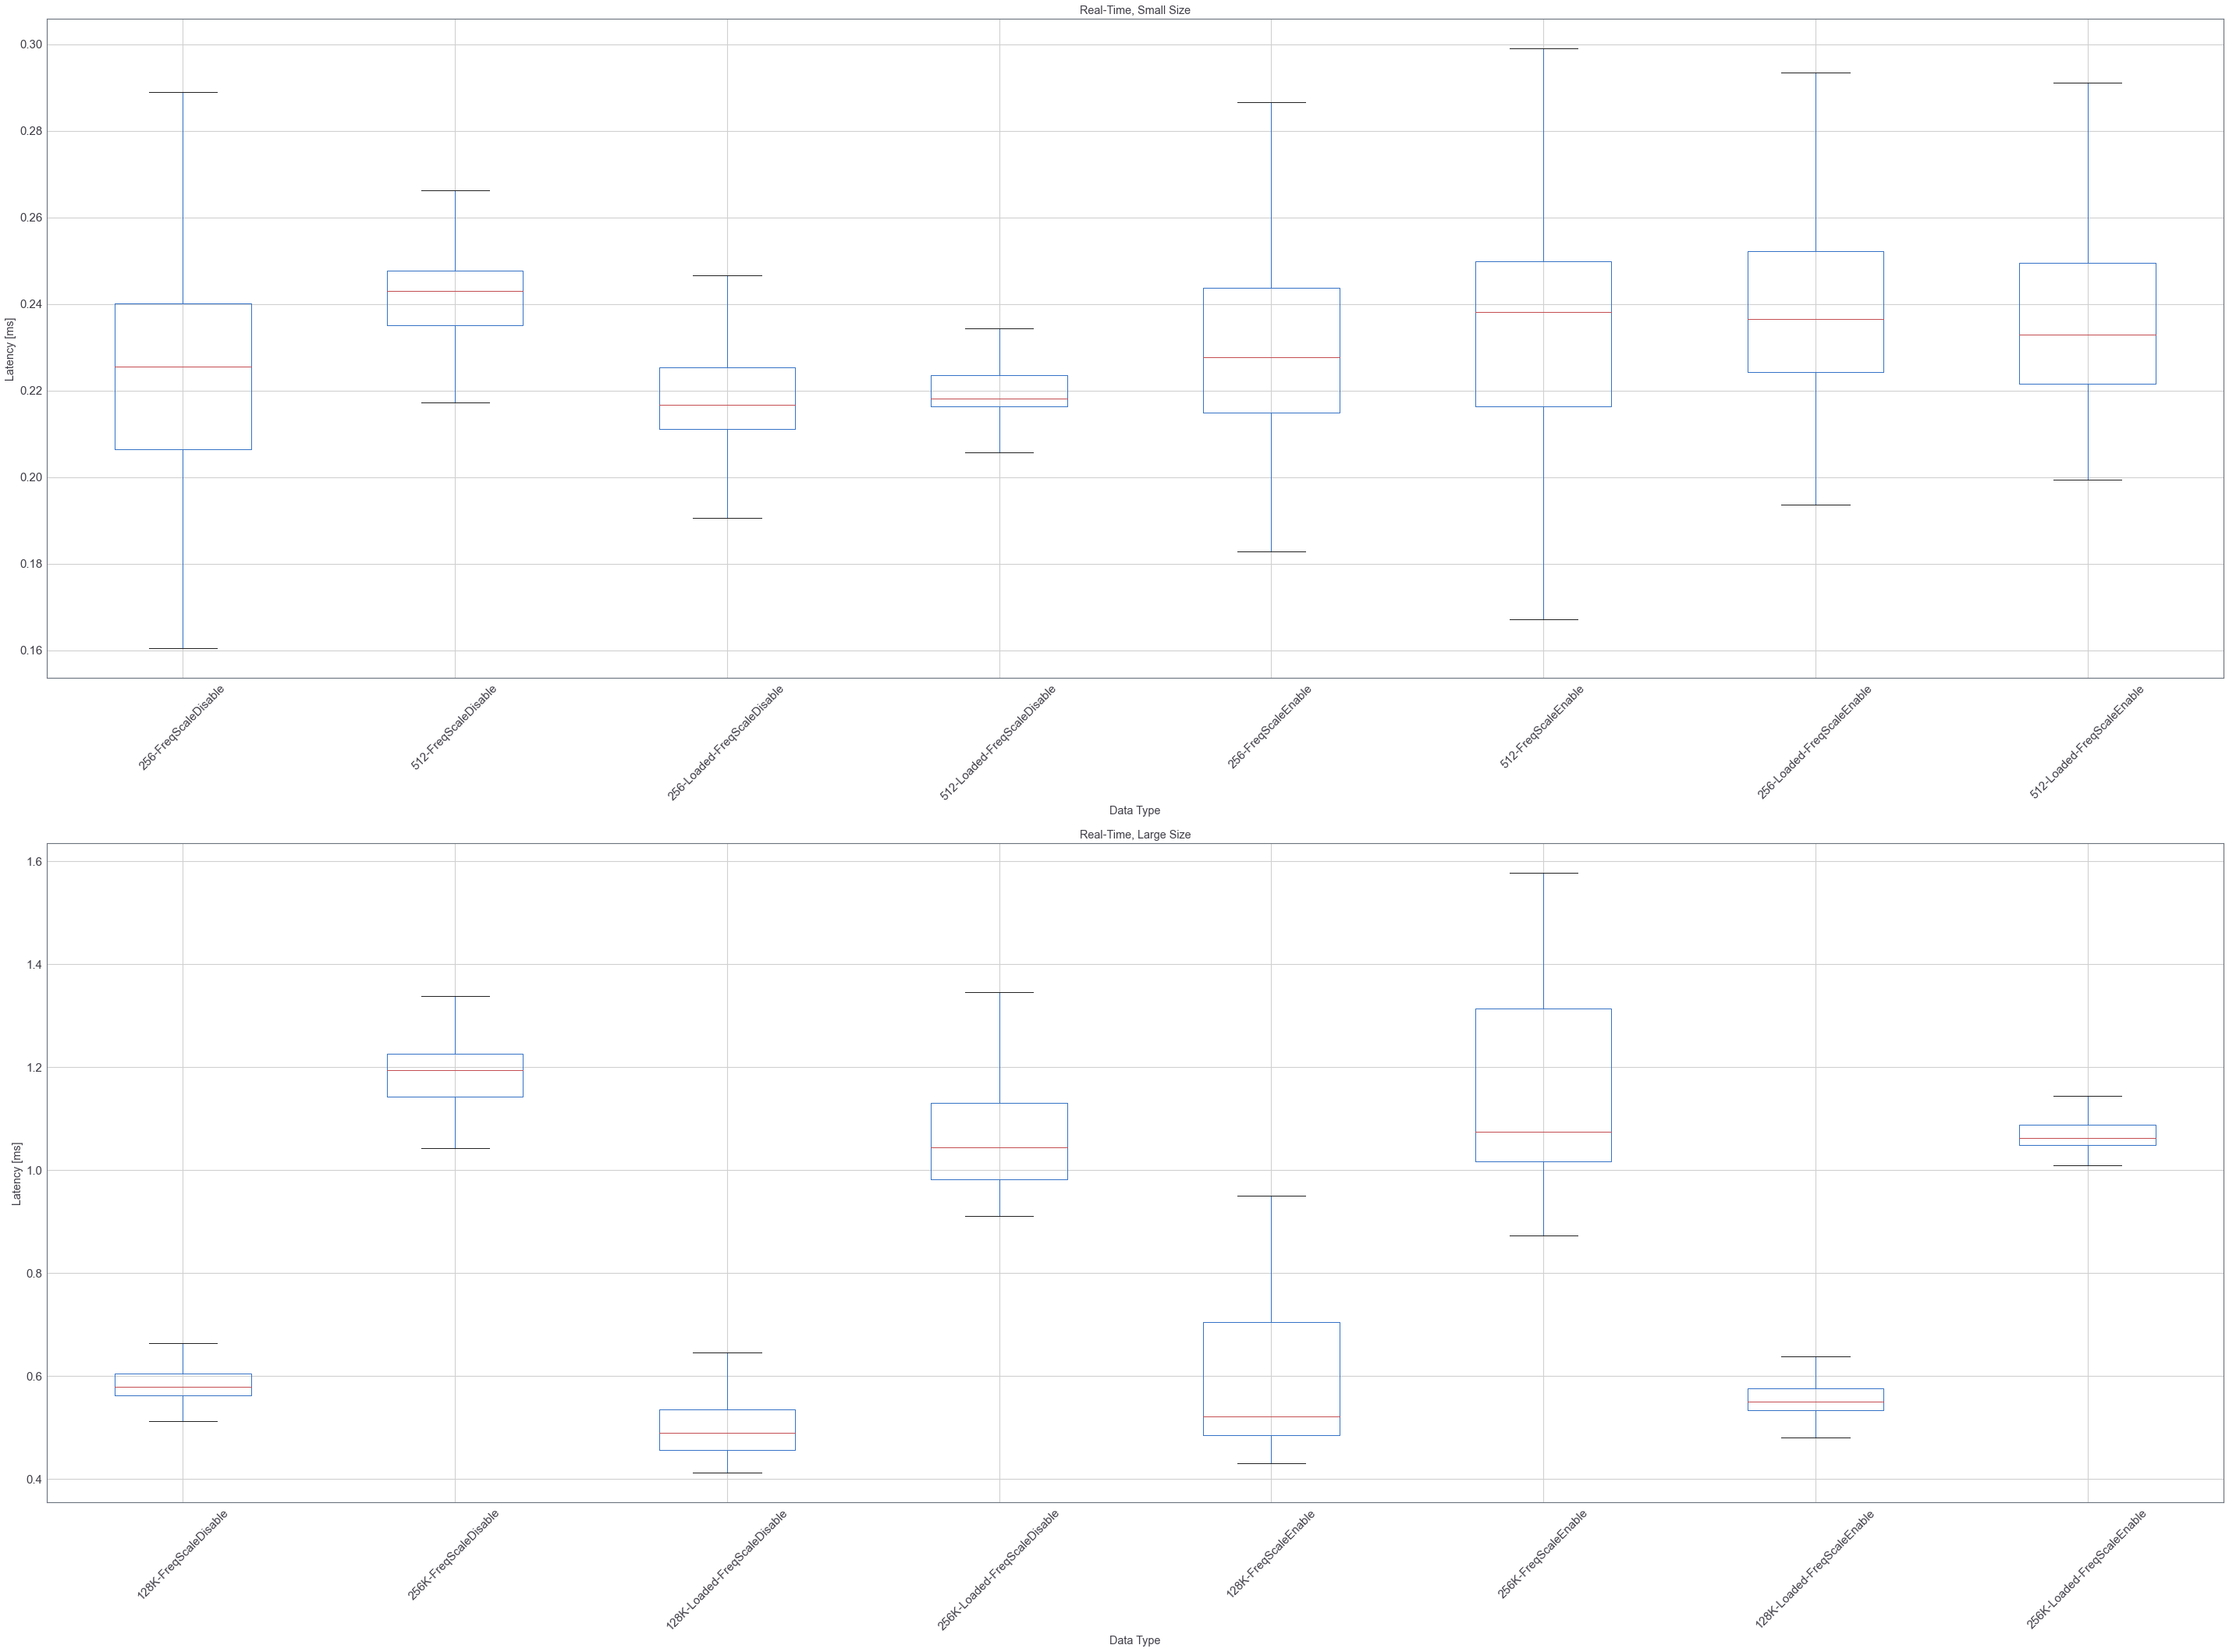

In [6]:
plt.figure(num=1, figsize=(50,35))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2,1,1)
boxplot = pd_rts.boxplot(rot=45, fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Type")
boxplot.set_title("Real-Time, Small Size")
plt.subplot(2,1,2)
boxplot = pd_rtl.boxplot(rot=45, fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Type")
boxplot.set_title("Real-Time, Large Size")
plt.savefig("./q5/figure/Boxplot_Real-Time.pdf", dpi=1600)

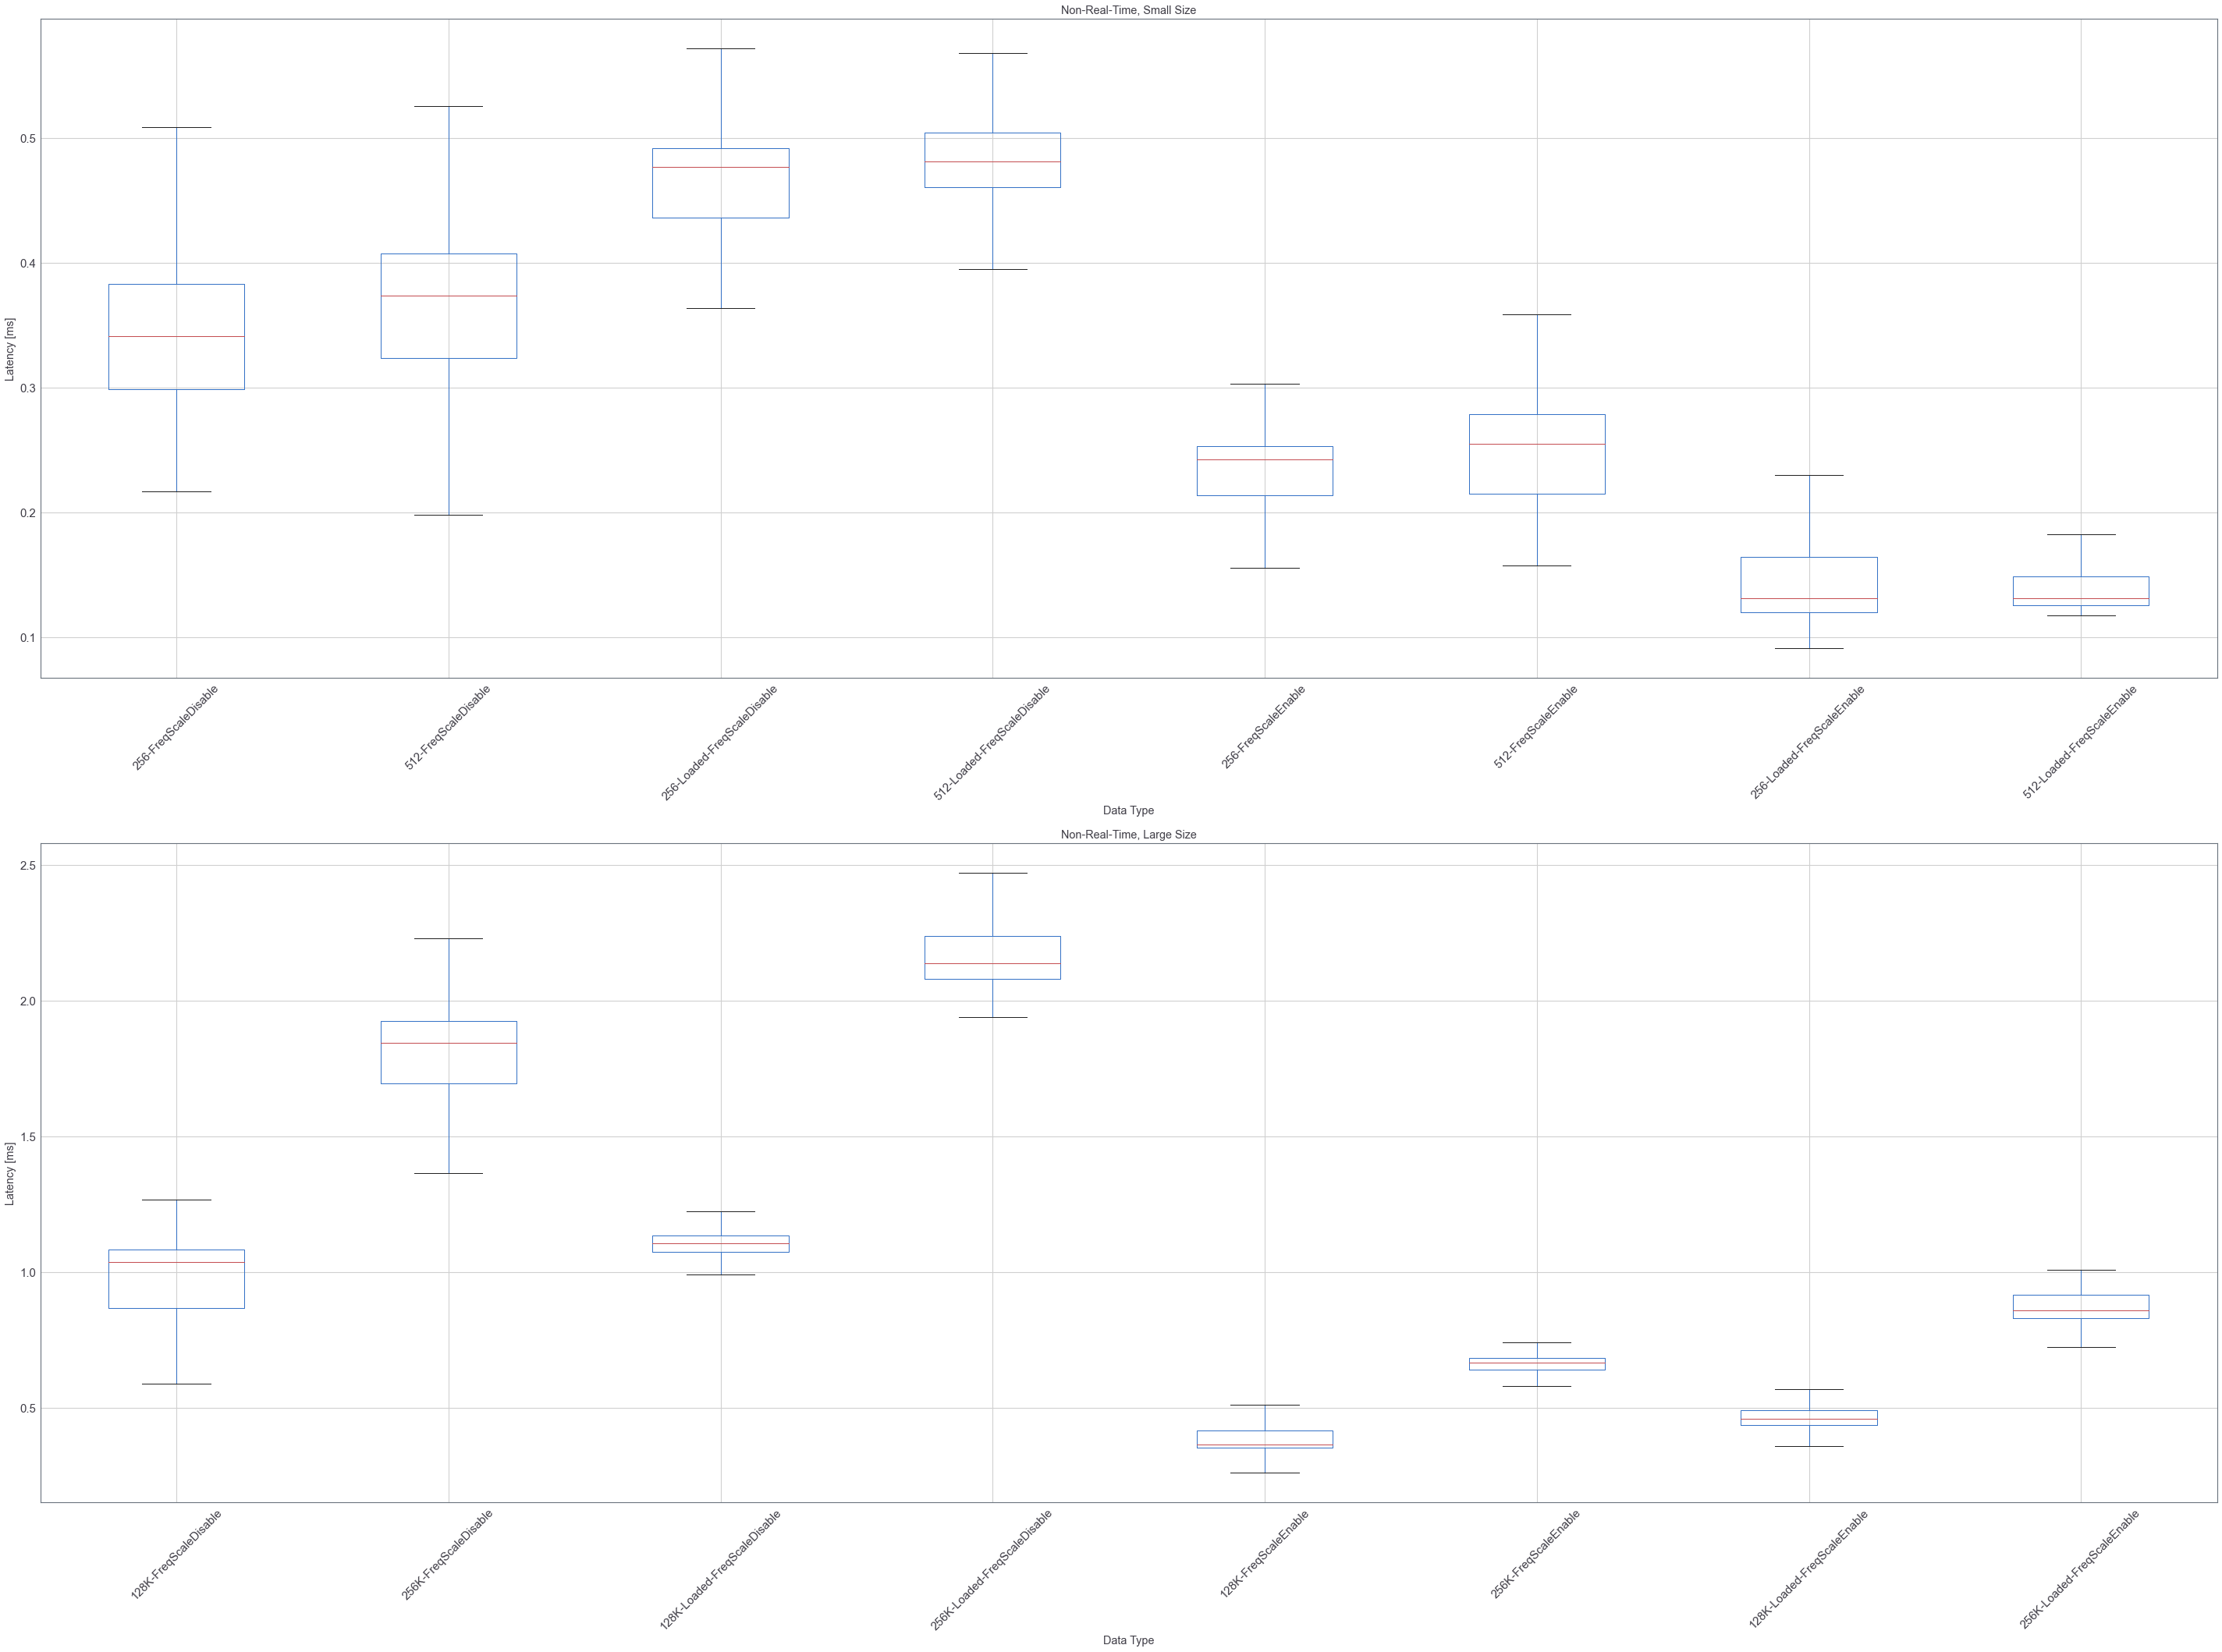

In [7]:
plt.figure(num=1, figsize=(50,35))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2,1,1)
boxplot = pd_nrts.boxplot(rot=45, fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Type")
boxplot.set_title("Non-Real-Time, Small Size")
plt.subplot(2,1,2)
boxplot = pd_nrtl.boxplot(rot=45, fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Type")
boxplot.set_title("Non-Real-Time, Large Size")
plt.savefig("./q5/figure/Boxplot_NonReal-Time.pdf", dpi=1600)

In [8]:
rtLoad_size = ["off_256", "off_512", "off_128K", "off_256K", "on_256", "on_512", "on_128K", "on_256K"]
df = pd.DataFrame(np.hstack((data[1,:,:], data[5,:,:])), columns=rtLoad_size)

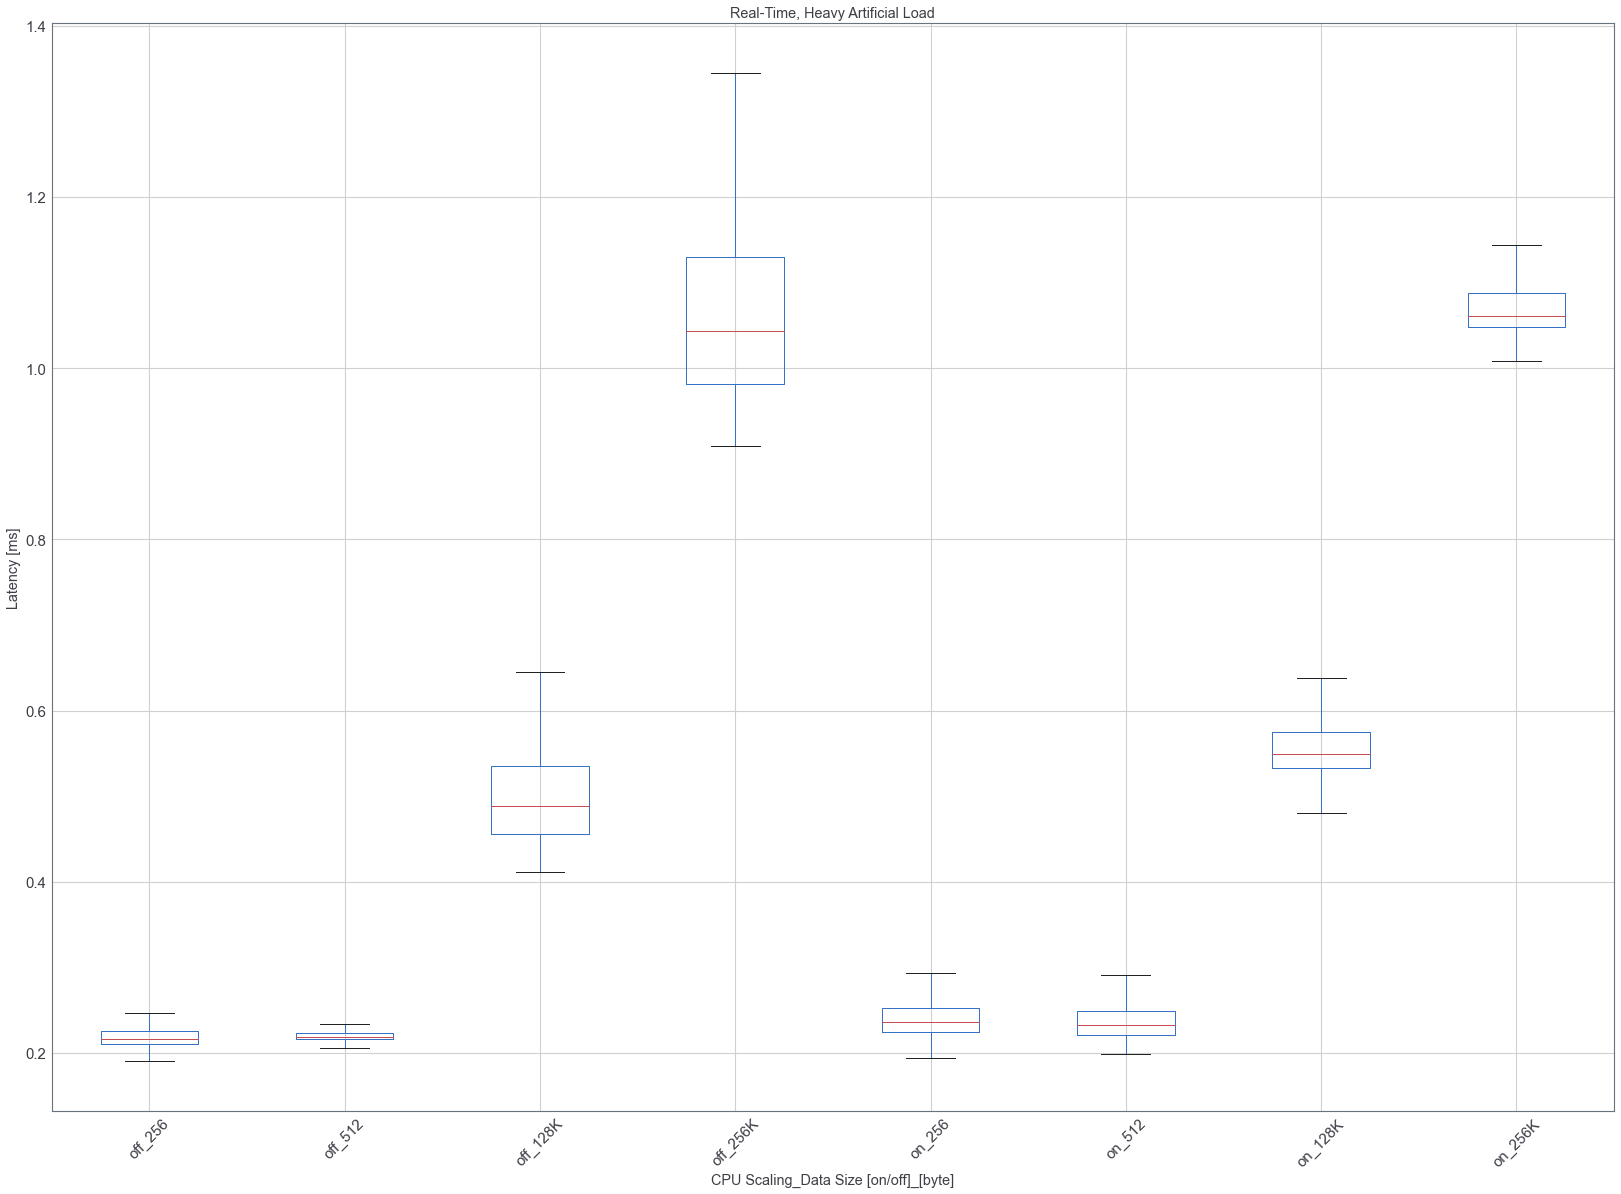

In [9]:
plt.figure(num=1, figsize=(28,20))
boxplot = df.boxplot(rot=45, fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("CPU Scaling_Data Size [on/off]_[byte]")
boxplot.set_title("Real-Time, Heavy Artificial Load")
plt.savefig("./q5/figure/Boxplot_rtLoad.pdf", dpi=1200)

# Histogram
In particular, compare the results you get for ”small and large message sizes” under ”heavy artificial load” and with ”real-time priorities”.

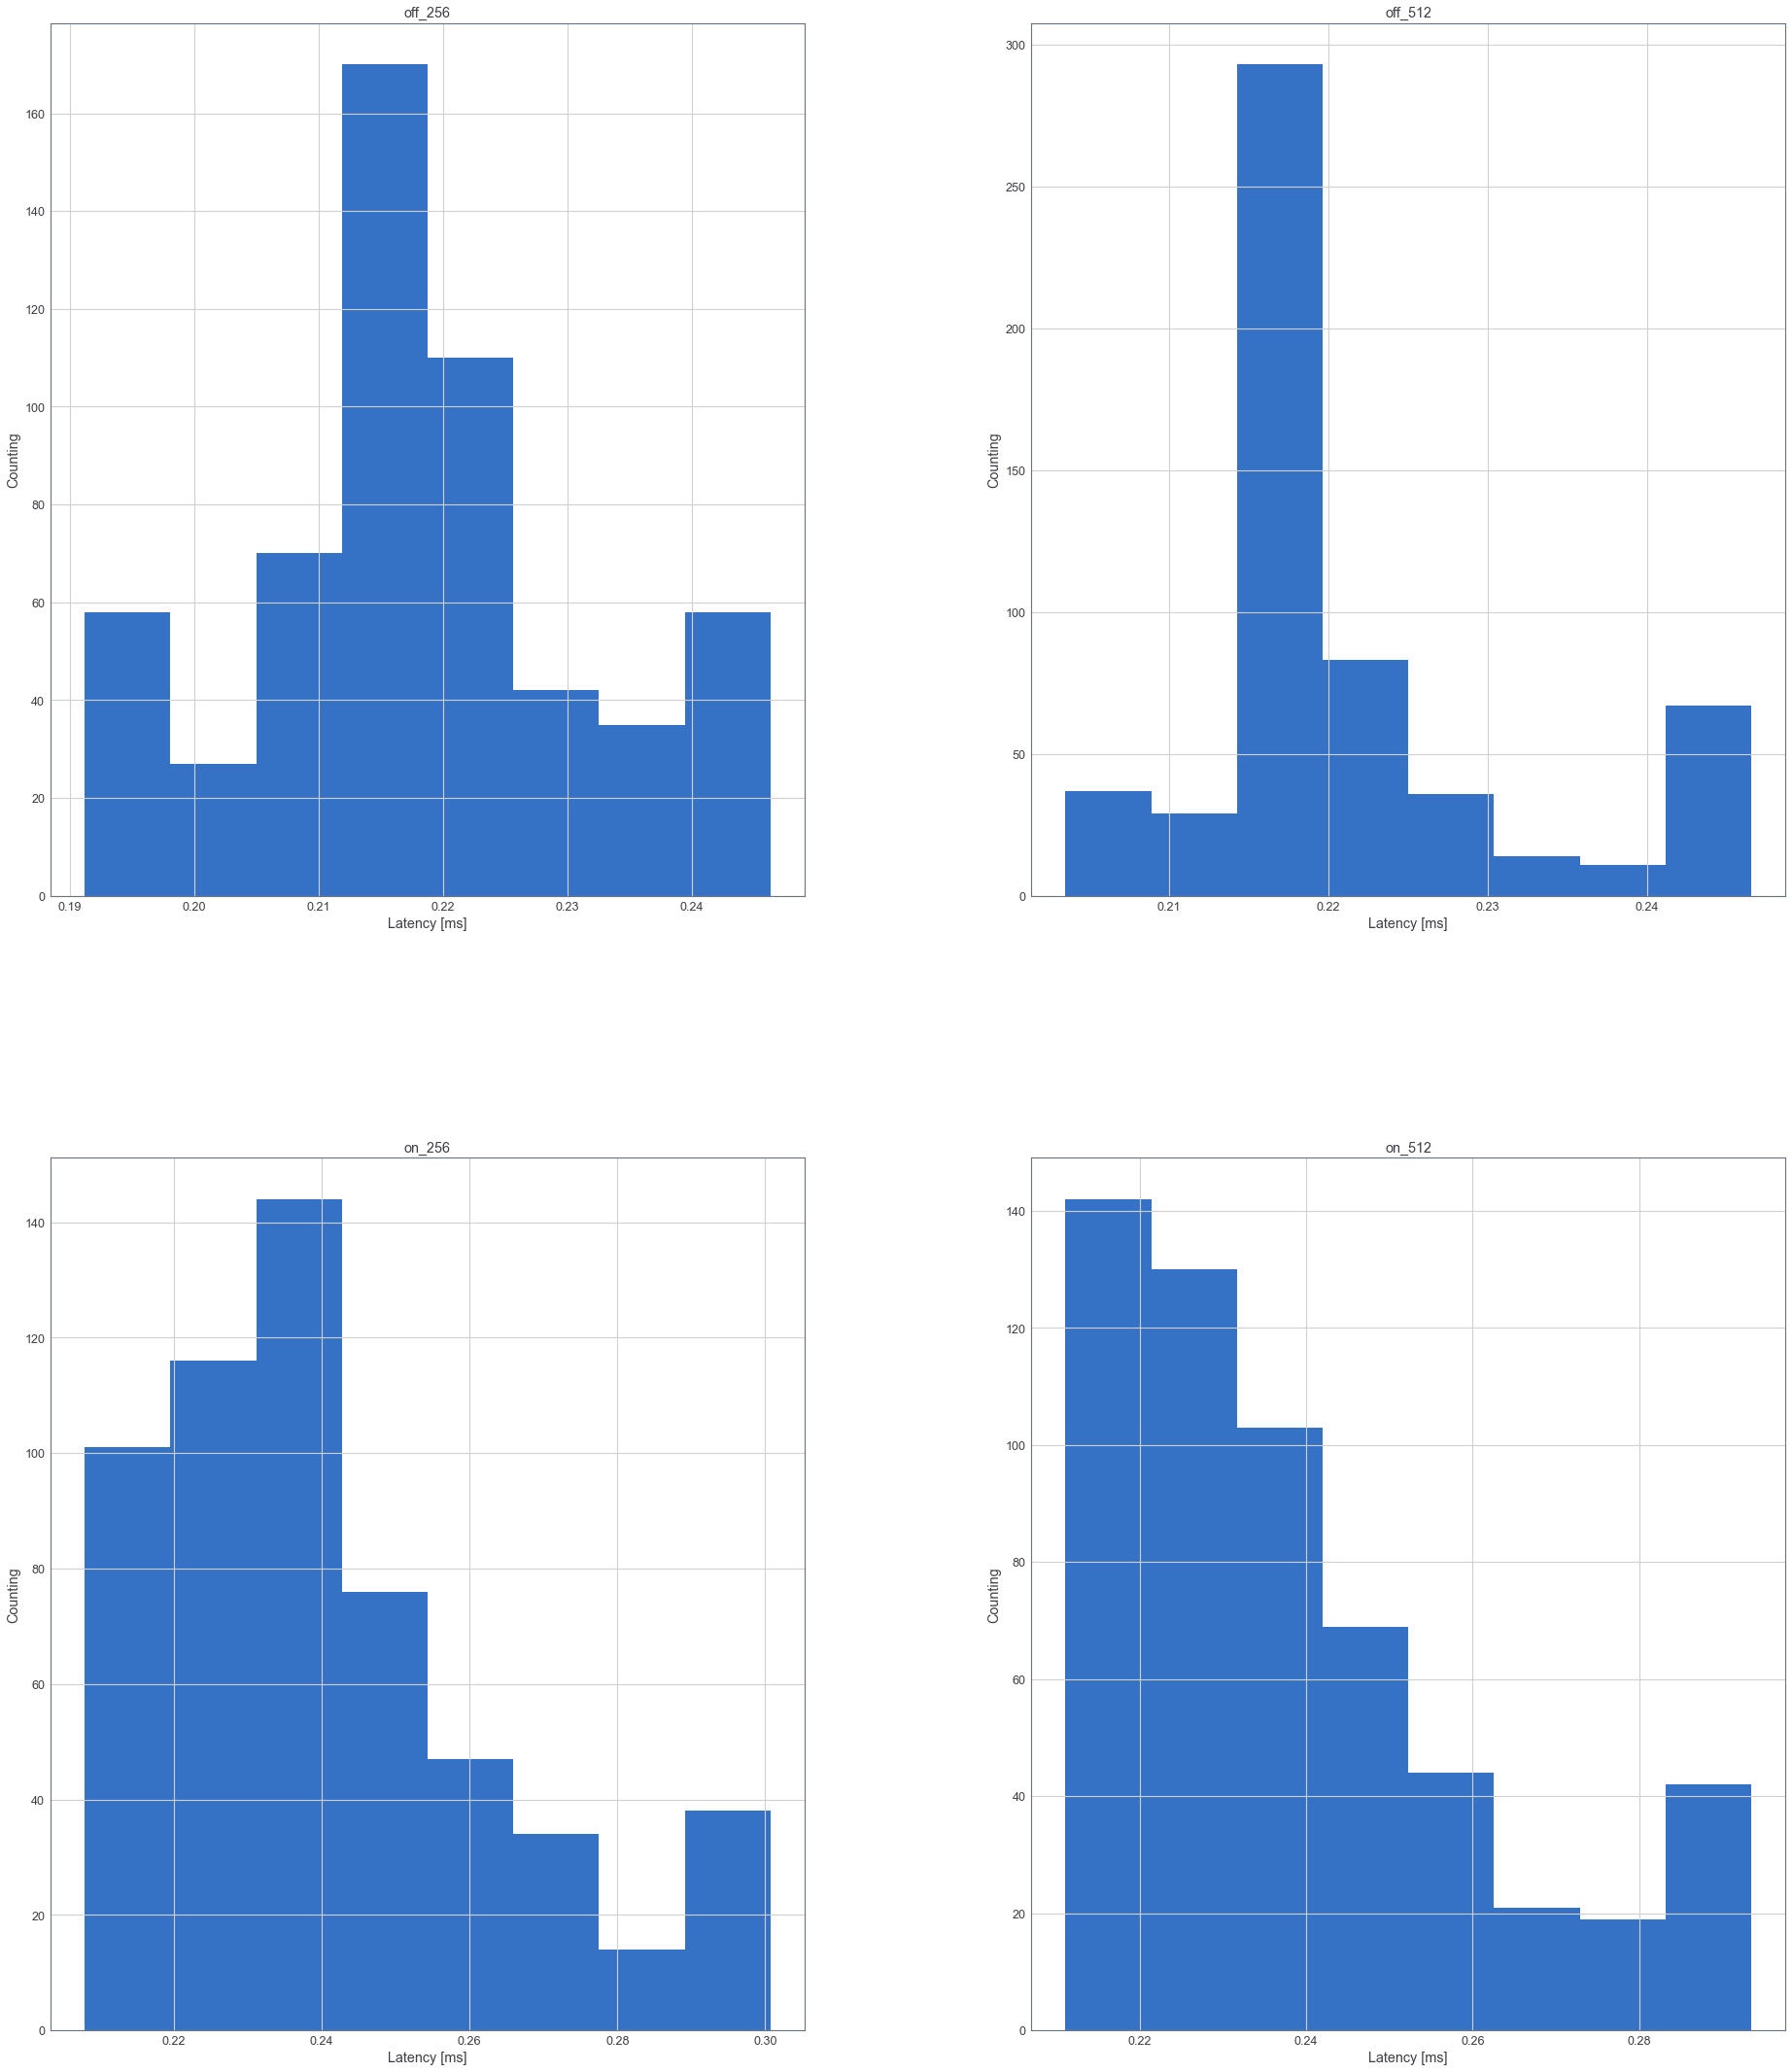

In [10]:
temp = df[["off_256", "off_512", "on_256", "on_512"]].apply(cap, quantile=[0.05,0.95])
hisFigAll = temp.hist(bins=8, figsize=(32,38))
for axis in hisFigAll.flatten():
    axis.set_xlabel("Latency [ms]")
    axis.set_ylabel("Counting")
plt.savefig("./q5/figure/His_rtLoad_small.pdf", dpi=1200)

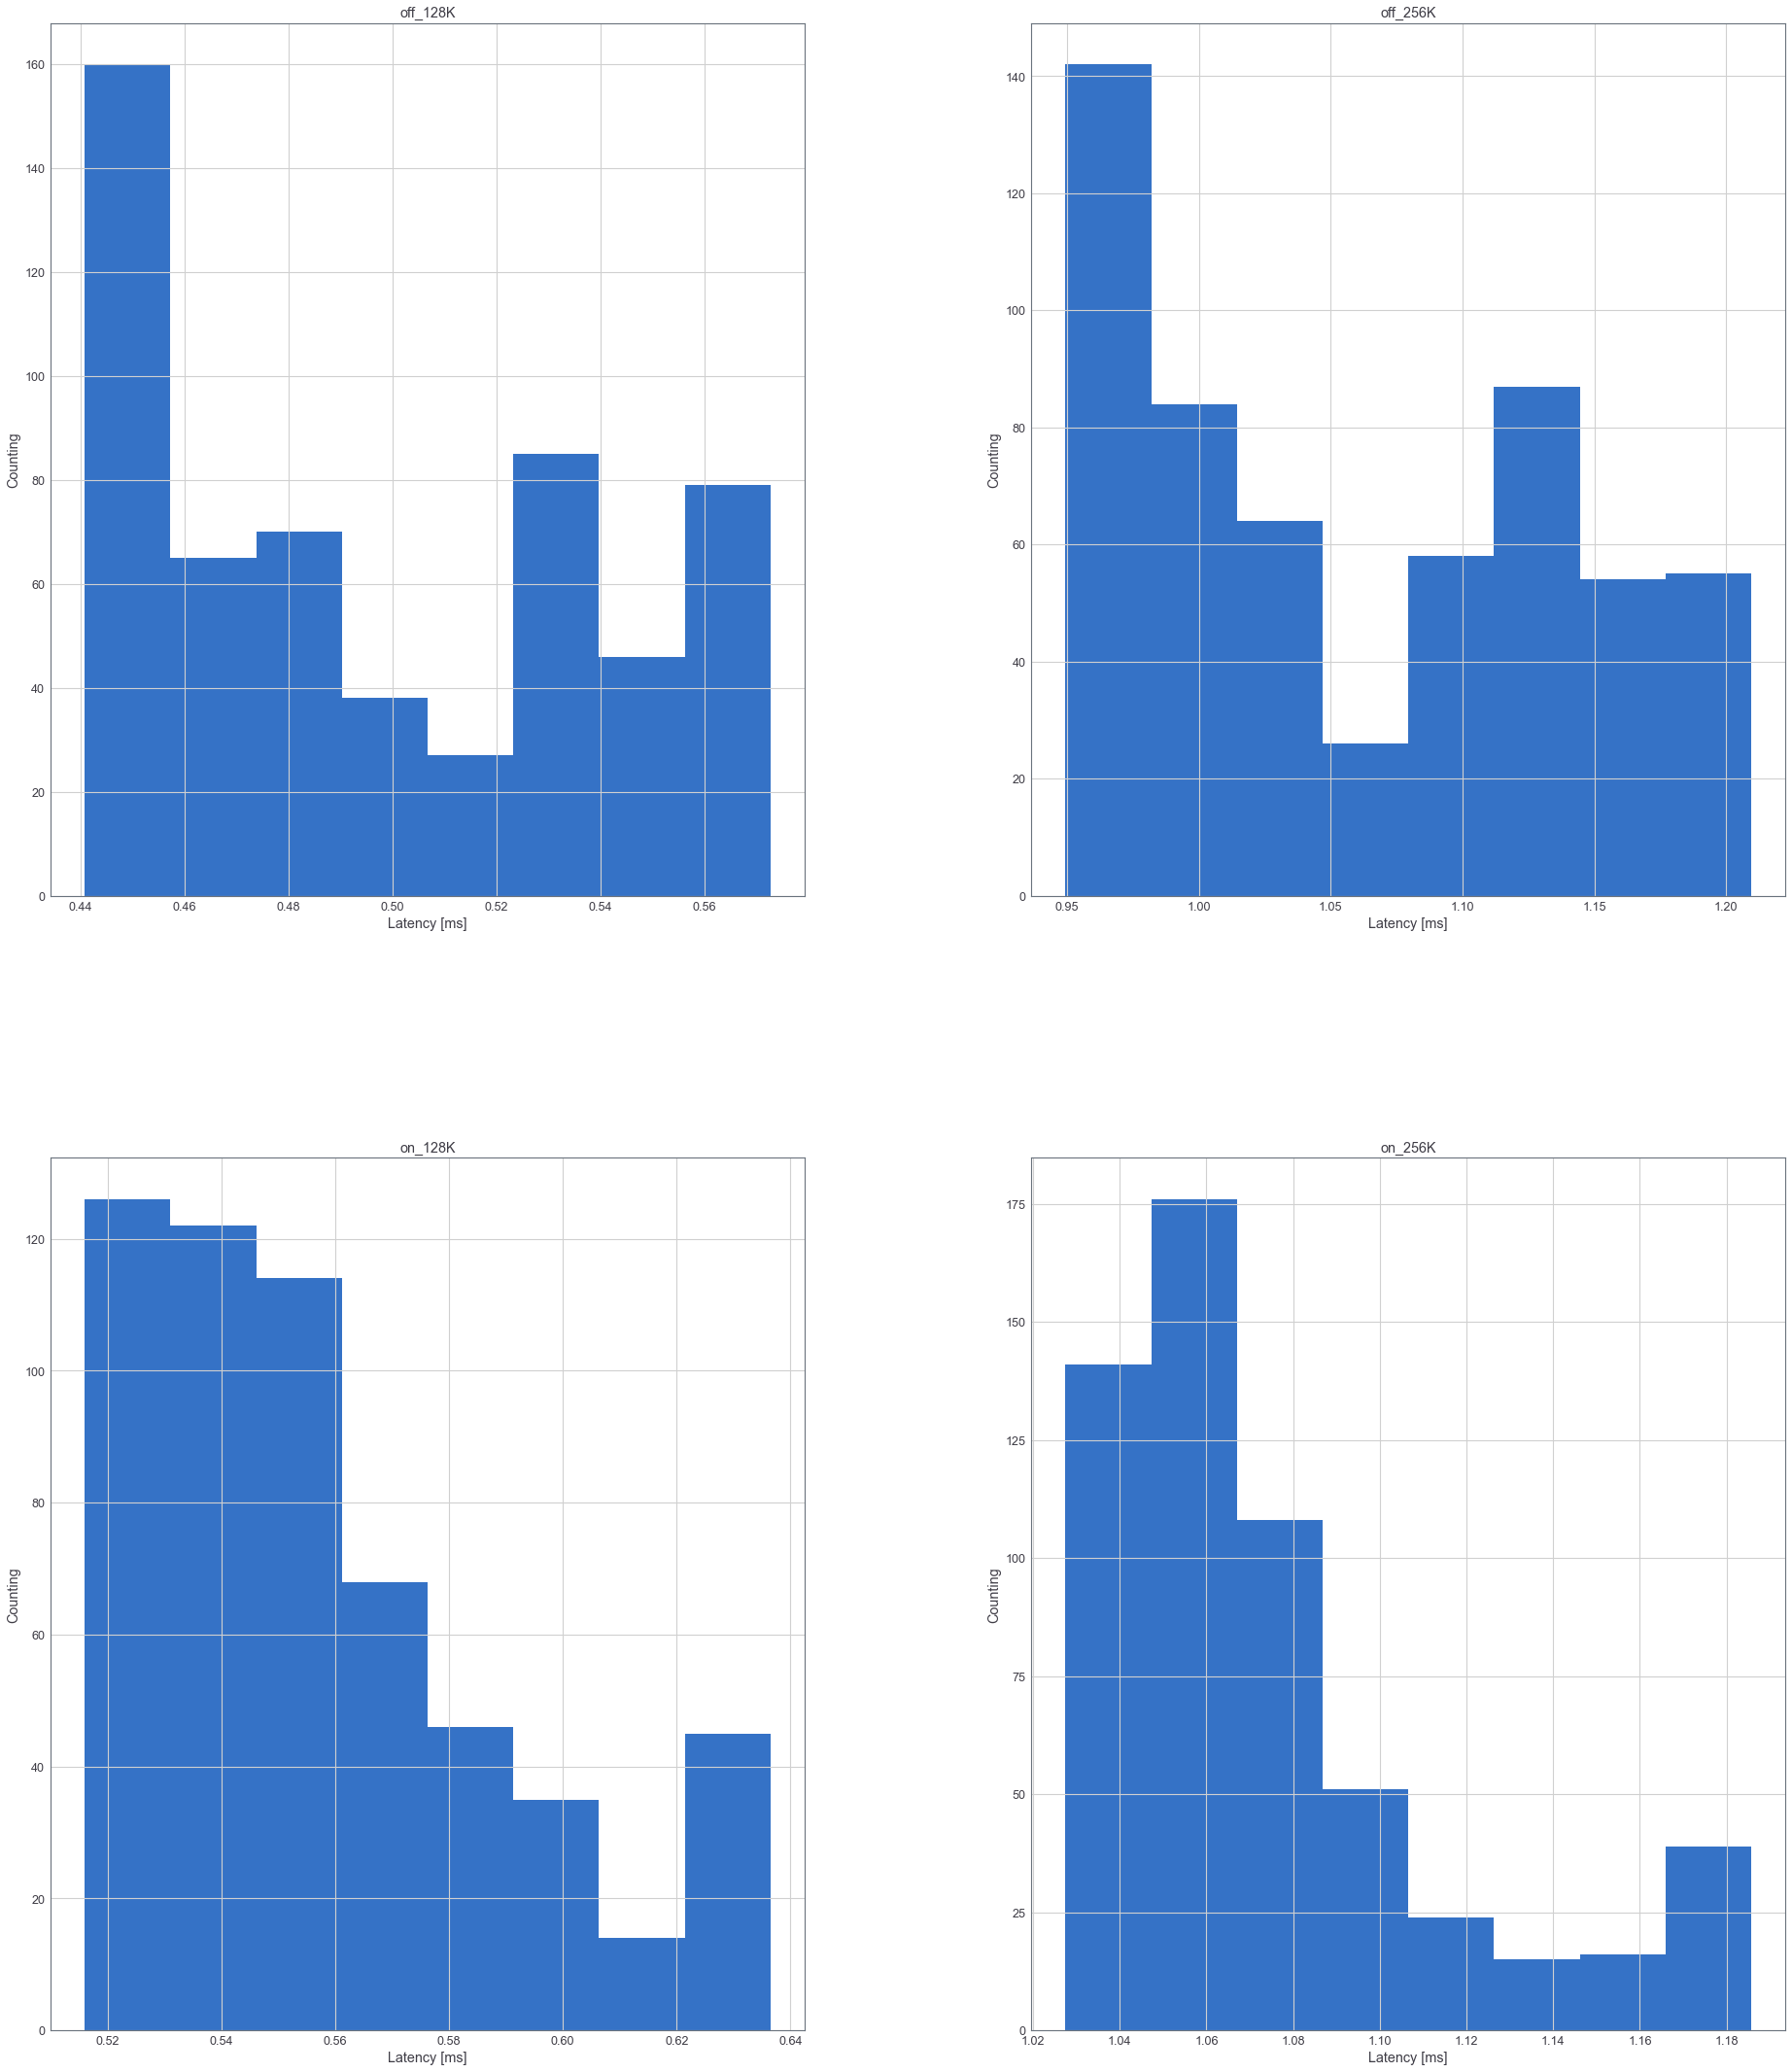

In [11]:
temp = df[["off_128K", "off_256K", "on_128K", "on_256K"]].apply(cap, quantile=[0.05,0.95])
hisFigAll = temp.hist(bins=8, figsize=(32,38))
for axis in hisFigAll.flatten():
    axis.set_xlabel("Latency [ms]")
    axis.set_ylabel("Counting")
plt.savefig("./q5/figure/His_rtLoad_large.pdf", dpi=1200)

# ANOVA

In [18]:
anova = pd.DataFrame({
    "latency": data.reshape(570,8*4).flatten("F"),
    
    "FreqScaling": np.repeat(["OFF", "NO"], 4*570*4),
    
    "Time": np.r_[np.repeat(["Real", "Non-Real"], 2*570*4),
                  np.repeat(["Real", "Non-Real"], 2*570*4)
                 ],
    
    "Loaded": np.r_[
        np.r_[np.repeat(["Load", "Unload"], 570*4),
             np.repeat(["Load", "Non-Unload"], 570*4)
            ],
        np.r_[np.repeat(["Load", "Unload"], 570*4),
             np.repeat(["Load", "Non-Unload"], 570*4)
            ]
    ],
    
    "Size": np.r_[
        np.r_[
            np.r_[
                np.repeat(["256", "512", "128K", "256K"], 570),
                np.repeat(["256", "512", "128K", "256K"], 570)
            ],
            np.r_[
                np.repeat(["256", "512", "128K", "256K"], 570),
                np.repeat(["256", "512", "128K", "256K"], 570)
            ]
        ],
        np.r_[
            np.r_[
                np.repeat(["256", "512", "128K", "256K"], 570),
                np.repeat(["256", "512", "128K", "256K"], 570)
            ],
            np.r_[
                np.repeat(["256", "512", "128K", "256K"], 570),
                np.repeat(["256", "512", "128K", "256K"], 570)
            ]
        ]
    ]
    
})

In [19]:
model_summary = rp.summary_cont(anova.groupby(['FreqScaling', 'Time', 'Loaded', 'Size']))['latency']
model_summary

N    Mean      SD      SE  95% Conf.  \
FreqScaling Time     Loaded     Size                                           
NO          Non-Real Load       128K  570  0.6355  0.2594  0.0109     0.6142   
                                256   570  0.2669  0.1039  0.0044     0.2583   
                                256K  570  1.3439  1.0823  0.0453     1.2549   
                                512   570  0.2726  0.1046  0.0044     0.2640   
                     Non-Unload 128K  570  0.6526  0.2665  0.0112     0.6307   
                                256   570  0.2768  0.1912  0.0080     0.2611   
                                256K  570  1.3837  1.2899  0.0540     1.2776   
                                512   570  0.2848  0.1886  0.0079     0.2693   
            Real     Load       128K  570  0.6390  0.2588  0.0108     0.6177   
                                256   570  0.2654  0.1026  0.0043     0.2569   
                                256K  570  1.3047  0.9176  0.0384     1.2292   
                                512   570  0.2765  0.1181  0.0049     0.2668   
                     Unload     128K  570  0.6455  0.2633  0.0110     0.6238   
                                256   570  0.2707  0.1162  0.0049     0.2611   
                                256K  570  1.3506  1.1239  0.0471     1.2581   
                                512   570  0.2746  0.1059  0.0044     0.2659   
OFF         Non-Real Load       128K  570  0.6416  0.2602  0.0109     0.6202   
                                256   570  0.2652  0.1013  0.0042     0.2569   
                                256K  570  1.2670  0.6679  0.0280     1.2121   
                                512   570  0.2751  0.1161  0.0049     0.2656   
                     Non-Unload 128K  570  0.6495  0.2905  0.0122     0.6256   
                                256   570  0.2664  0.1024  0.0043     0.2580   
                                256K  570  1.2475  0.5066  0.0212     1.2058   
                                512   570  0.2749  0.1060  0.0044     0.2662   
            Real     Load       128K  570  0.6404  0.2627  0.0110     0.6188   
                                256   570  0.2635  0.0986  0.0041     0.2554   
                                256K  570  1.3239  1.0228  0.0428     1.2397   
                                512   570  0.2764  0.1079  0.0045     0.2676   
                     Unload     128K  570  0.6528  0.2736  0.0115     0.6303   
                                256   570  0.2649  0.1025  0.0043     0.2565   
                                256K  570  1.2948  0.8848  0.0371     1.2220   
                                512   570  0.2739  0.1048  0.0044     0.2653   

                                      Interval  
FreqScaling Time     Loaded     Size            
NO          Non-Real Load       128K    0.6569  
                                256     0.2754  
                                256K    1.4330  
                                512     0.2812  
                     Non-Unload 128K    0.6745  
                                256     0.2925  
                                256K    1.4898  
                                512     0.3003  
            Real     Load       128K    0.6603  
                                256     0.2738  
                                256K    1.3802  
                                512     0.2862  
                     Unload     128K    0.6672  
                                256     0.2802  
                                256K    1.4430  
                                512     0.2834  
OFF         Non-Real Load       128K    0.6630  
                                256     0.2735  
                                256K    1.3220  
                                512     0.2847  
                     Non-Unload 128K    0.6734  
                                256     0.2748  
                                256K    1.2891  
                                512     0.2836  
            Real     Load       128K    0.662

In [20]:
model = ols('latency ~ C(FreqScaling) + C(Time) + C(Loaded) + C(Size) + C(FreqScaling)*C(Time) + C(FreqScaling)*C(Loaded) + C(FreqScaling)*C(Size)'
            , anova).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 13, 18226) =  986.204, p =  0.0000


In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                latency   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     986.2
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:12:12   Log-Likelihood:                -13534.
No. Observations:               18240   AIC:                         2.710e+04
Df Residuals:                   18226   BIC:                         2.721e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.6389      0.014     45.363      0.000       0.611       0.667
C(FreqScaling)[T.OFF]                             0.0020      0.020      0.102      0.919      -0.037       0.041
C(Time)[T.Real]                                  -0.0084      0.015     -0.555      0.579      -0.038       0.021
C(Loaded)[T.Non-Unload]                           0.0197      0.015      1.311      0.190      -0.010       0.049
C(Loaded)[T.Unload]                               0.0140      0.015      0.927      0.354      -0.016       0.043
C(Size)[T.256]                                   -0.3732      0.015    -24.788      0.000      -0.403      -0.344
C(Size)[T.256K]                                   0.7026      0.015     46.660      0.000       0.673       0.732
C(Size)[T.512]                                   -0.3660      0.015    -24.309      0.000      -0.396      -0.337
C(FreqScaling)[T.OFF]:C(Time)[T.Real]             0.0222      0.021      1.041      0.298      -0.020       0.064
C(FreqScaling)[T.OFF]:C(Loaded)[T.Non-Unload]    -0.0224      0.021     -1.052      0.293      -0.064       0.019
C(FreqScaling)[T.OFF]:C(Loaded)[T.Unload]        -0.0184      0.021     -0.865      0.387      -0.060       0.023
C(FreqScaling)[T.OFF]:C(Size)[T.256]             -0.0078      0.021     -0.368      0.713      -0.050       0.034
C(FreqScaling)[T.OFF]:C(Size)[T.256K]            -0.0653      0.021     -3.069      0.002      -0.107      -0.024
C(FreqScaling)[T.OFF]:C(Size)[T.512]             -0.0050      0.021     -0.233      0.816      -0.047       0.037
==============================================================================
Omnibus:                    33336.441   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         54891987.812
Skew:                          13.570   Prob(JB):                         0.00
Kurtosis:                     270.376   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(FreqScaling),1.259108,1.0,4.871857,0.027311
C(Time),0.017030,1.0,0.065892,0.797417
C(Loaded),0.218165,2.0,0.422073,0.655692
C(Size),3307.584597,3.0,4266.005559,0.000000
C(FreqScaling):C(Time),0.280189,1.0,1.084134,0.297788
C(FreqScaling):C(Loaded),0.479057,2.0,0.926807,0.395834
C(FreqScaling):C(Size),3.225328,3.0,4.159914,0.005919
Residual,4710.420247,18226.0,NaN,NaN


In [23]:
res.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &       sum\\_sq &       df &            F &    PR(>F) \\\\\n\\midrule\nC(FreqScaling)           &     1.259108 &      1.0 &     4.871857 &  0.027311 \\\\\nC(Time)                  &     0.017030 &      1.0 &     0.065892 &  0.797417 \\\\\nC(Loaded)                &     0.218165 &      2.0 &     0.422073 &  0.655692 \\\\\nC(Size)                  &  3307.584597 &      3.0 &  4266.005559 &  0.000000 \\\\\nC(FreqScaling):C(Time)   &     0.280189 &      1.0 &     1.084134 &  0.297788 \\\\\nC(FreqScaling):C(Loaded) &     0.479057 &      2.0 &     0.926807 &  0.395834 \\\\\nC(FreqScaling):C(Size)   &     3.225328 &      3.0 &     4.159914 &  0.005919 \\\\\nResidual                 &  4710.420247 &  18226.0 &          NaN &       NaN \\\\\n\\bottomrule\n\\end{tabular}\n'